In [1]:
import json, os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils
import copy
def annToRLE(segm, h, w):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    if type(segm) == list:
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == list:
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle

def annToMask(segm, h, w):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(segm, h, w)
    m = maskUtils.decode(rle)
    return m

def get_anno(anno, img_id, order_id):
    anno_item = [anno for anno in jfile['annotations'] if anno['image_id']==img_id and anno['order']==order_id]
    assert len(anno_item)==1
    return anno_item[0]

def add_color_to_image(img, mask_np, color):
    img_np = np.array(img.convert("RGB"))
    if len(mask_np.shape)==2:
        mask_np = mask_np[:,:,None]
    assert(len(color))==3
    color_np = np.array(color)
    if len(color_np.shape)==1:
        color_np = color_np.reshape((1,1,3))
    img_np = img_np * (1-mask_np) + color_np*mask_np*0.5 + img_np*mask_np*0.5
    return Image.fromarray(img_np.astype(np.uint8),"RGB")


img_id: 100, occlusion order: 1-9,1-10,1-11,2-1,2-10,2-11,5-1,5-2,5-3,5-9,5-10,5-11,6-1,6-5,6-10,8-6,9-1,10-1,11-1,11-9


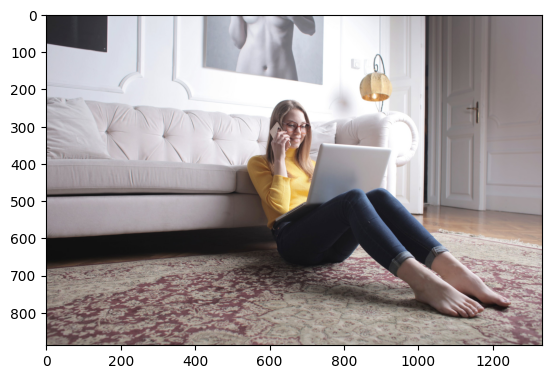

In [2]:
jfile=json.load(open('val_image_anno.json','r'))
img_idx = 100
img_filename = jfile['images'][img_idx]['file_name']
img_id = jfile['images'][img_idx]['id']
img_w, img_h = jfile['images'][img_idx]['width'], jfile['images'][img_idx]['height']
occlusion_order = jfile['images'][img_idx]['depth_constraint']
print(f"img_id: {img_id}, occlusion order: {occlusion_order}")
img = Image.open(os.path.join('val/', img_filename))
img = img.resize((img_w,img_h), Image.LANCZOS)
plt.imshow(img)
plt.show()

mutual occulsion case:
occlusion between 1 (green) and 9 (blue)


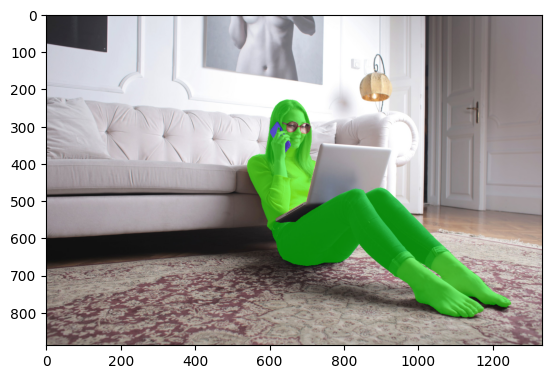

amodal mask


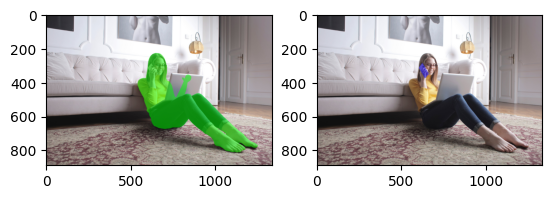

In [3]:
for occ_item in occlusion_order.split(','):
    occ_id_occludee, occ_id_occluder = occ_item.split('-')
    if f"{occ_id_occluder}-{occ_id_occludee}" in occlusion_order.split(','):
        print("mutual occulsion case:")
    anno_occludee = get_anno(jfile['annotations'], img_id, int(occ_id_occludee))
    anno_occluder = get_anno(jfile['annotations'], img_id, int(occ_id_occluder))
    mask_occludee = annToMask(anno_occludee['visible_mask'], img_h, img_w)
    amodal_occludee = annToMask(anno_occludee['segmentation'], img_h, img_w)
    mask_occluder = annToMask(anno_occluder['visible_mask'], img_h, img_w)
    amodal_occluder = annToMask(anno_occluder['segmentation'], img_h, img_w)
    img_color = add_color_to_image(img, mask_occludee, [0,255,0])
    img_color = add_color_to_image(img_color, mask_occluder, [0,0,255])
    print(f"occlusion between {occ_id_occludee} (green) and {occ_id_occluder} (blue)")
    
    plt.imshow(img_color)
    plt.show()
    print(f"amodal mask")
    plt.subplot(1,2,1)
    plt.imshow(add_color_to_image(img, amodal_occludee, [0,255,0]))
    plt.subplot(1,2,2)
    plt.imshow(add_color_to_image(img, amodal_occluder, [0,0,255]))
    plt.show()
    break